In [11]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import llops as yp
import comptic
import llops.operators as ops

from pyfpm import fpm

yp.setDefaultDatatype('complex32')
yp.setDefaultBackend('arrayfire')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate Object

<IPython.core.display.Javascript object>


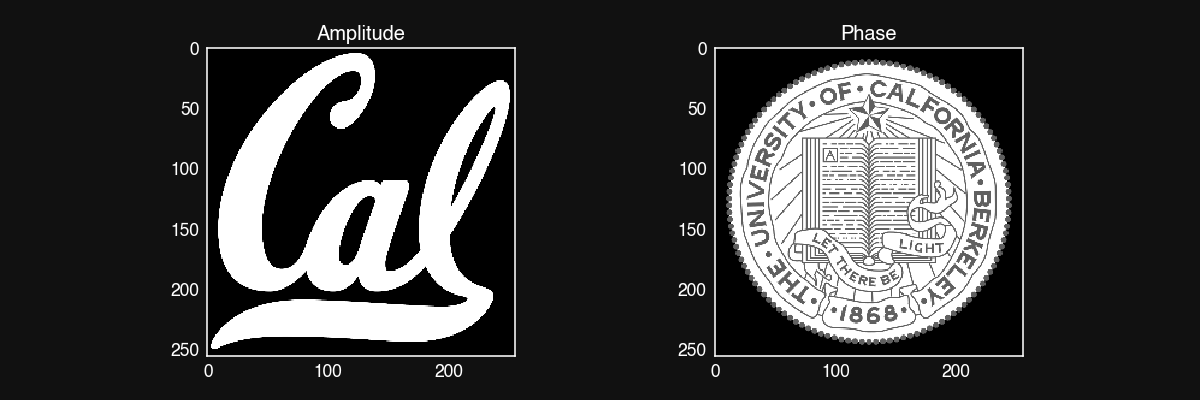

Text(0.5, 1.0, 'Phase')

In [12]:
object_shape = (256, 256)
object_true = yp.simulation.ucb(object_shape)

plt.figure()
plt.subplot(121)
plt.imshow(yp.abs(object_true))
plt.title('Amplitude')
plt.subplot(122)
plt.imshow(yp.angle(object_true))
plt.title('Phase')

## Define Settings

<IPython.core.display.Javascript object>


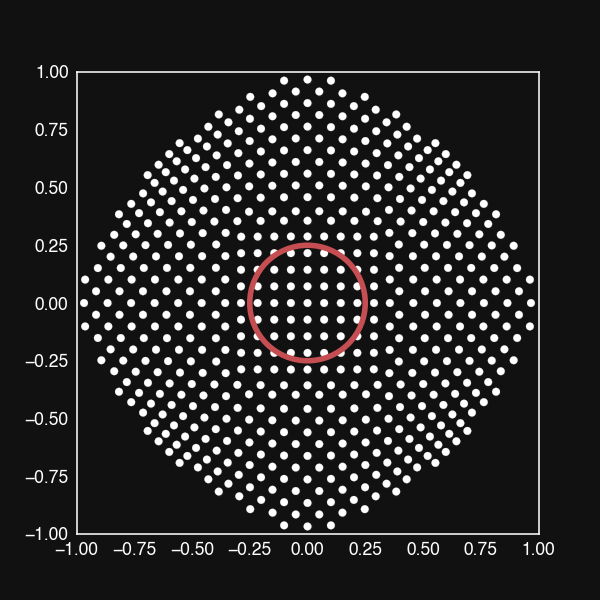

In [13]:
# Generate system parameters
system_parameters = fpm.getDefaultSystemParams(pixel_count=object_shape)

# Show led positions
fpm.plotLedPattern( **system_parameters)

## Generate Pupil Function

In [14]:
# Generate Pupil
pupil = comptic.imaging.pupil(object_shape, **system_parameters)

KeyError: 'i1'

## Generate LED Sequences

In [8]:
# def generateLedSequences(brightfield_pattern_type='single', darkfield_pattern_type='single', 
#                          illumination_source_position_list_na=[], 
#                          objective_numerical_aperture=0.25):
    
#     # Initialize LED intensity list
#     led_pattern_list = []
    
#     # Divide led list into brightfield and darkfield
#     brightfield_led_list = [led_pos for led_pos in illumination_source_position_list_na if np.sqrt(led_pos[0] ** 2 + led_pos[1] ** 2) <= objective_numerical_aperture]
#     darkfield_led_list = [led_pos for led_pos in illumination_source_position_list_na if np.sqrt(led_pos[0] ** 2 + led_pos[1] ** 2) > objective_numerical_aperture]
    
#     # Develop brightfield list
#     if brightfield_pattern_type = 'single':
#         led_pattern_list += 
        
    

In [6]:
# Select LED pattern. Should be a list of list of integers; each internal list has the LED id positions which are illuminated.
single = [[i] for i, x in enumerate(system_parameters['illumination_source_position_list_na'])]
multiplexed = [[4 * i + j for j in range(4)] for i in range(8)]
patterns = single

## Generate Forward Models

In [7]:
I = ops.Intensity(object_shape)
R = ops.PhaseRamp(object_shape)
F = ops.FourierTransform(object_shape)

P = ops.Diagonalize(pupil, label='\\tilde P')

led_position_list_na = system_parameters['illumination_source_position_list_na']
illumination_wavelength = system_parameters['illumination_wavelength']

# Derived constants
effective_pixel_size = system_parameters['camera_pixel_size'] / system_parameters['objective_magnification'] 
dky, dkx = [1 / (sz * effective_pixel_size) for sz in object_shape]

A_list, y_list = [], []
for pattern_index, led_pattern in enumerate(yp.display.progressBar(patterns, name='Forward Models Generated')):
    A_pattern = None
    
    # Loop over all LEDs in this pattern
    for led_id in led_pattern:
        led_position_na = led_position_list_na[led_id]
        
        # Determine the shift of the LED position in pixels
        pixel_shift = (np.asarray(led_position_na).astype(np.complex64) / illumination_wavelength) / np.asarray([dkx, dky]).astype(np.complex64)
        
        # Create phase ramp multiplication operator
        S = ops.Diagonalize(R * pixel_shift, label='S_{' + str(pattern_index) + '}')
        
        # Generate complete forward model
        _A = I * (F.H * P * F * S)
        
        # Add this forward operator to the list
        A_pattern = _A if not A_pattern else A_pattern + _A
    
    # Append forward model to list
    A_list.append(A_pattern)
    
    # Generate measurement
    y_list.append(A_pattern * object_true)
    
# Combine these operators into a set if vertically stacked measurements
A = ops.Vstack(A_list)

# Create measurements
y = ops.VecStack(y_list)

## Create Objective Function

In [9]:
objective = yp.solvers.objectivefunctions.L2(A, y)

## Perform Gradient Descent

In [10]:
# Define Initialization
initialization = yp.ones(object_shape)

# Solve by accelerated gradient descent
x_opt = yp.solvers.GradientDescent(objective).solve(iteration_count=20, display_type='text', step_size=5e-3,
                                                     use_nesterov_acceleration=True, nesterov_restart_enabled=True, initialization=initialization)

# Show recovered object
plt.figure()
plt.subplot(121)
plt.imshow(np.abs(x_opt), cmap = 'gray')
plt.title('Reconstructed Amp')

plt.subplot(122)
plt.imshow(np.angle(x_opt), cmap = 'gray')
plt.title('Reconstructed Phase')

plt.tight_layout()
plt.show()

Minimizing function:


<IPython.core.display.Latex object>

|  Iter  |      Cost      | Elapsed time (s) |  Norm of Step  | Memory Usage (CPU/GPU) |
+ ------ + -------------- + ---------------- + -------------- + ---------------------- +
|    0   |    3.01e+05    |       0.00       |    0.00e+00    | 1680.9 MB /    0.0 MB  |


KeyboardInterrupt: 